# MULTI-STRATEGY

In [1]:
import pandas as pd
import itable
import ffn
import talib

%matplotlib inline

def side_by_side(*objs, **kwds):
    from pandas.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))

# Portfolio Moving Average (PMA), Relative Strength (RS) and Dual Momentum (DM) Backtests

In [2]:
import os
os.chdir('C:\\users\\scuba\\pycharmprojects\\simplebacktester')
os.getcwd()

'C:\\users\\scuba\\pycharmprojects\\simplebacktester'

RS0001

VCVSX

VWEHX

VFIIX

FGOVX

VWAHX

FIRST BUY DATE = 1986-07-31 00:00:00



PMA003

VCVSX

VGHCX

VUSTX

FAGIX

FIRST BUY DATE = 1986-07-31 00:00:00



RS0002

MMHYX

FAGIX

VFIIX

FIRST BUY DATE = 1984-05-31 00:00:00



PMA001

VFIIX

VCVSX

VUSTX

FIRST BUY DATE = 1986-08-29 00:00:00



PMA002

VWINX

VCVSX

VUSTX

VWEHX

FIRST BUY DATE = 1986-08-29 00:00:00



DM0001

VCVSX

VWAHX

VUSTX

FGOVX

VFIIX

VGHCX

FFXSX

VWINX

VWEHX

FIRST BUY DATE = 1986-12-31 00:00:00



RS0003

MMHYX

FAGIX

VFIIX

FIRST BUY DATE = 1984-05-31 00:00:00



DM0002

VCVSX

VUSTX

VFIIX

VGHCX

FRESX

FFXSX

VWEHX

FIRST BUY DATE = 1986-12-31 00:00:00




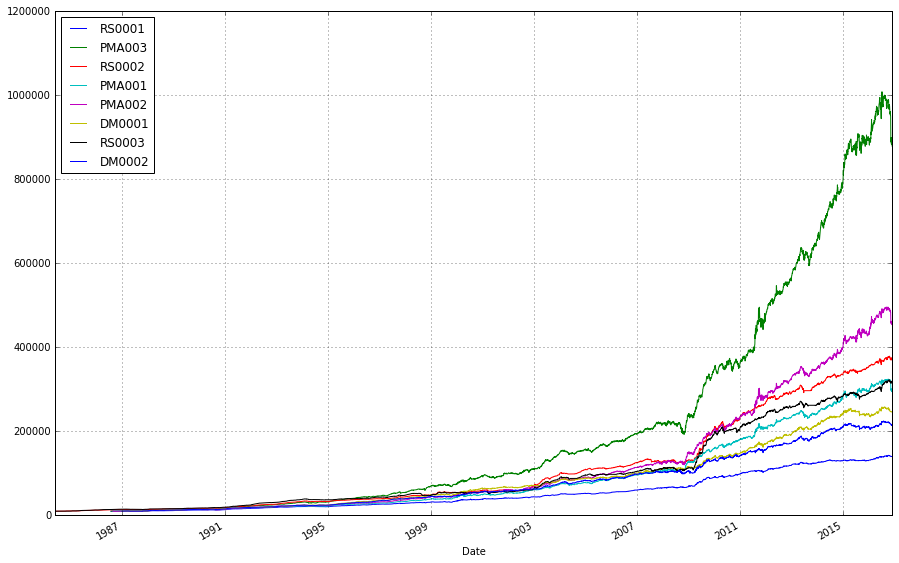

In [30]:
import pandas as pd
import ffn

%matplotlib inline

from backtest_helpers.compute_weights_RS_DM import compute_weights_RS_DM
from backtest_helpers.compute_weights_PMA import compute_weights_PMA
from backtest_helpers.monthly_return_table import monthly_return_table
from backtest_helpers.endpoints import endpoints
from backtest_helpers.backtest import backtest

strategies = {
    'RS0001': { 'symbols': ['VCVSX','VWEHX','VFIIX','FGOVX','VWAHX'], 'prices': 'yahoo',  
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 2, 'frequency': 'm',
              'cash_proxy': 'CASHX', 'risk_free': 0},
    'RS0002': {'symbols': ['MMHYX','FAGIX','VFIIX'],  'prices': 'yahoo', 
               'rs_lookback': 3, 'risk_lookback': 2, 'n_top': 1, 'frequency': 'm',
              'cash_proxy': 'CASHX', 'risk_free': 0},
    'RS0003': {'symbols': ['MMHYX','FAGIX','VFIIX'], 'prices': 'yahoo', 
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 1, 'frequency': 'q',
              'cash_proxy': 'CASHX', 'risk_free': 0},    
    'DM0001': {'symbols': ['VCVSX','VWINX','VWEHX','VGHCX','VUSTX','VFIIX','VWAHX','FGOVX','FFXSX'],
                'prices': 'yahoo', 
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 3, 'frequency': 'm',
              'cash_proxy': 'CASHX', 'risk_free': 'FFXSX'},
    'DM0002': {'symbols': ['VCVSX','VUSTX','VWEHX','VFIIX','VGHCX','FRESX'], 'prices': 'yahoo', 
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 5, 'frequency': 'm',
              'cash_proxy': 'VFIIX', 'risk_free': 'FFXSX'},
    'PMA001': {'symbols': ['VCVSX', 'VFIIX'],  'prices': 'yahoo', 
               'risk_lookback': 3, 'frequency': 'm', 'allocations': [0.6, 0.4],
              'cash_proxy': 'VUSTX'},
    'PMA002': {'symbols': ['VCVSX', 'VWINX', 'VWEHX'], 'prices': 'yahoo', 
               'risk_lookback': 3, 'frequency': 'm', 'allocations': [0.6, 0.2, 0.2],
              'cash_proxy': 'VUSTX'},
    'PMA003': {'symbols': ['VCVSX', 'FAGIX', 'VGHCX'], 'prices': 'yahoo',  
               'risk_lookback': 2, 'frequency': 'm', 'allocations': [1./3., 1./3., 1./3.],
              'cash_proxy': 'VUSTX'},    
}

strategy_values = pd.DataFrame(columns=strategies.keys())
security_weights = {}
security_holdings = {}
prices = {}

for name in strategies :
    if 'PMA' in name :
        s_value, s_holdings, s_weights, s_prices =  compute_weights_PMA (name, strategies[name])
    else :
        s_value, s_holdings, s_weights, s_prices =  compute_weights_RS_DM (name, strategies[name])
    
    strategy_values[name] = s_value
    security_weights[name] = s_weights
    security_holdings[name] = s_holdings
    prices[name] = s_prices

In [4]:
index = strategy_values.dropna().index
rebalance_dates = endpoints(period='m', trading_days=index)

In [5]:
# find the set of all portfolio symbols
n = len(strategies)
l = [list(security_weights[name].columns) for name in strategies]
s = []
for i in range(n) :
    s = s + l[i]
    
aggregated_weights = pd.DataFrame(0, index=rebalance_dates, columns=list(set(s)))
all_prices = pd.DataFrame(0, index=index, columns=list(set(s)))
aggregated_weights[:1]

,VWEHX,VCVSX,VWAHX,FGOVX,FAGIX,VUSTX,VFIIX,VGHCX,FRESX,MMHYX,FFXSX,VWINX,CASHX
1986-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# for equally weighted strategies
strategy_weights = pd.Series([1. / n for i in range(n)], index=list(strategies.keys()))
strategy_weights

RS0001    0.125

PMA003    0.125

RS0002    0.125

PMA001    0.125

PMA002    0.125

DM0001    0.125

RS0003    0.125

DM0002    0.125

dtype: float64

In [7]:
for name in strategies :
    aggregated_weights[security_weights[name].columns] += security_weights[name].loc[rebalance_dates] * strategy_weights[name]
    all_prices = prices[name].loc[index].combine_first(all_prices)

In [13]:
aggregated_weights[:3].round(3)

,VWINX,VWEHX,VGHCX,FGOVX,VCVSX,VFIIX,MMHYX,VUSTX,VWAHX,FRESX,FFXSX,FAGIX,CASHX
1986-12-31,0.000,0.154,0.000,0.0,0.000,0.354,0.125,0.367,0.000,0.000,0.0,0.000,0.0
1987-01-30,0.067,0.050,0.108,0.0,0.321,0.200,0.125,0.000,0.062,0.025,0.0,0.042,0.0
1987-02-27,0.025,0.154,0.108,0.0,0.321,0.050,0.000,0.025,0.000,0.025,0.0,0.292,0.0


In [8]:
from backtest_helpers.backtest import backtest
p_value, p_holdings, p_weights = backtest(all_prices, aggregated_weights, 10000., offset=0, commission=10.)

FIRST BUY DATE = 1986-12-31 00:00:00




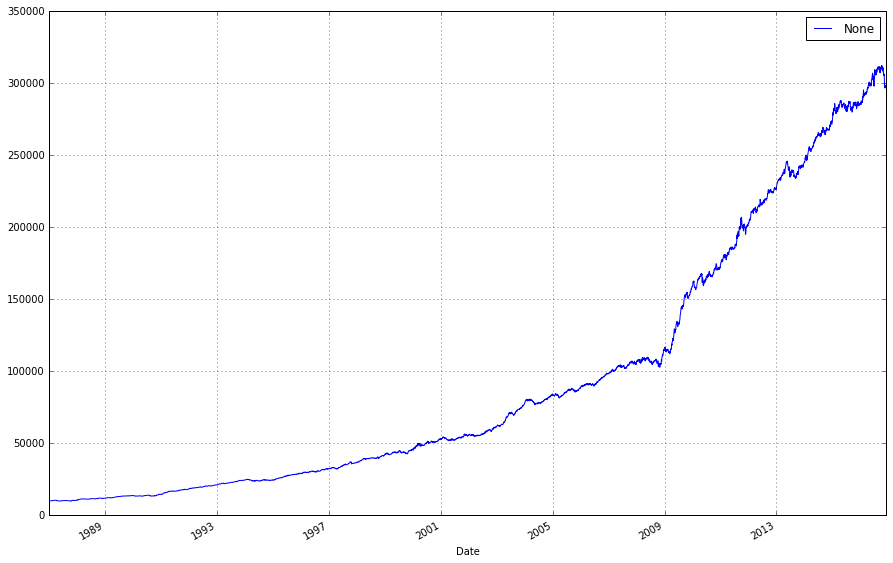

In [9]:
p_value.plot(figsize=(15,10), grid=True, legend=True)

In [10]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 1986-12-31 00:00:00 - 2016-11-30 00:00:00

Annual risk-free rate considered: 0.00%

Summary:

Total Return      Sharpe  CAGR    Max Drawdown

--------------  --------  ------  --------------

2871.02%            2.27  12.00%  -6.37%



Annualized Returns:

mtd     3m      6m      ytd    1y     3y     5y     10y     incep.

------  ------  ------  -----  -----  -----  -----  ------  --------

-3.22%  -4.28%  -1.84%  3.90%  3.96%  6.91%  8.26%  11.70%  12.00%



Periodic:

        daily    monthly    yearly

------  -------  ---------  --------

sharpe  2.27     2.10       1.56

mean    11.46%   11.54%     12.22%

vol     5.05%    5.50%      7.81%

skew    -0.02    0.20       1.55

kurt    4.82     0.96       3.69

best    3.12%    6.78%      38.82%

worst   -2.85%   -3.52%     -0.12%



Drawdowns:

max     avg       # days

------  ------  --------

-6.37%  -0.68%     15.51



Misc:

---------------  ------

avg. up month    1.64%

avg. down month  -1.00%

up year % 

G:\Anaconda3\lib\site-packages\ffn\core.py:190: FutureWarning: how in .resample() is deprecated

the new syntax is .resample(...).last()

  self.monthly_prices = obj.resample('M', how='last')

G:\Anaconda3\lib\site-packages\ffn\core.py:193: FutureWarning: how in .resample() is deprecated

the new syntax is .resample(...).last()

  self.yearly_prices = obj.resample('A', how='last')


In [11]:
def highlight_pos_neg (s) :
    is_positive = s > 0    
    return ['background-color : rgb(127,255,0)' if v else 'background-color : rgb(255,99,71)' for v in is_positive]

df = monthly_return_table (p_value)

df.style.\
    apply(highlight_pos_neg)

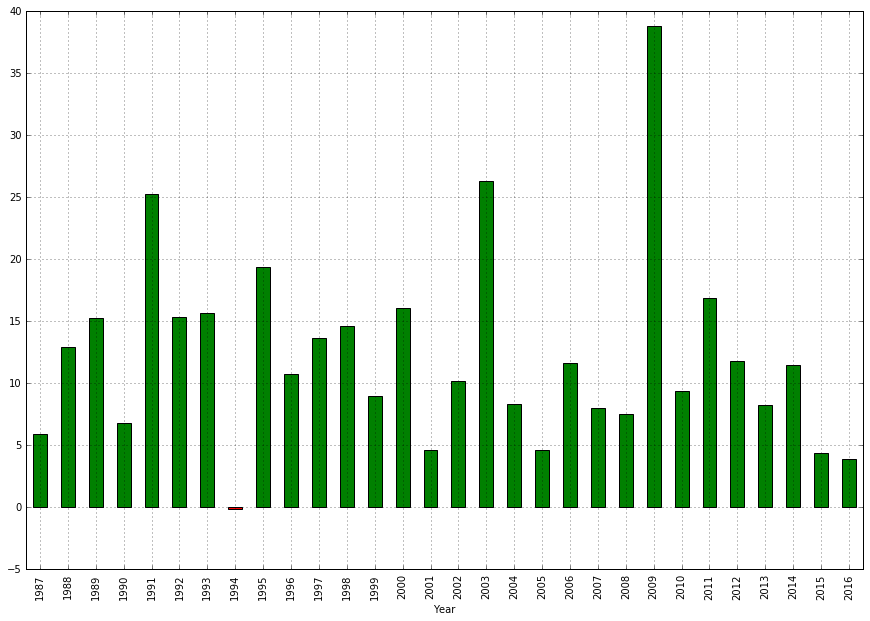

In [12]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

### Need to determine the holdings of each security

In [13]:
p_holdings.loc[rebalance_dates].round(0)[:5]

,CASHX,FAGIX,FFXSX,FGOVX,FRESX,MMHYX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,,,,,
1986-12-31,0.0,0.0,0.0,0.0,0.0,805.0,0.0,2092.0,0.0,2717.0,0.0,2117.0,0.0
1987-01-30,0.0,539.0,0.0,0.0,115.0,804.0,2565.0,1182.0,355.0,0.0,332.0,680.0,310.0
1987-02-27,0.0,3822.0,0.0,0.0,115.0,0.0,2485.0,299.0,359.0,188.0,0.0,2106.0,119.0
1987-03-31,0.0,3818.0,181.0,0.0,114.0,0.0,2177.0,453.0,349.0,193.0,0.0,2108.0,0.0
1987-04-30,3801.0,1627.0,0.0,0.0,0.0,0.0,0.0,761.0,0.0,2944.0,0.0,0.0,0.0


In [14]:
transactions = (p_holdings - p_holdings.shift(1).fillna(0))
transactions = transactions[transactions.sum(1) != 0]
transactions.round(0)[:5]

,CASHX,FAGIX,FFXSX,FGOVX,FRESX,MMHYX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,,,,,
1986-12-31,0.0,0.0,0.0,0.0,0.0,805.0,0.0,2092.0,0.0,2717.0,0.0,2117.0,0.0
1987-01-30,0.0,539.0,0.0,0.0,115.0,-1.0,2565.0,-910.0,355.0,-2717.0,332.0,-1437.0,310.0
1987-02-27,0.0,3284.0,0.0,0.0,1.0,-804.0,-80.0,-882.0,4.0,188.0,-332.0,1426.0,-191.0
1987-03-31,0.0,-5.0,181.0,0.0,-1.0,0.0,-308.0,154.0,-10.0,4.0,0.0,2.0,-119.0
1987-04-30,3801.0,-2191.0,-181.0,0.0,-114.0,0.0,-2177.0,308.0,-349.0,2751.0,0.0,-2108.0,0.0


In [15]:
def generate_orders(transactions, prices) :
    orders = pd.DataFrame()
    for i in range(len(transactions)):
        for j in range(len(transactions.columns)):
            t = transactions.ix[i]
            qty = abs(t[j])
            if qty >= 1.:
                if transactions.ix[i][j] < 0 :
                    orders = orders.append([[t.name.date().year, t.name.date().month, t.name.date().day, t.index[j],\
                                             'Sell', -abs(t[j]), prices.ix[t.name][t.index[j]]]])
                if transactions.ix[i][j] > 0 :
                    orders = orders.append([[t.name.date().year, t.name.date().month, t.name.date().day, t.index[j],\
                                             'Buy', abs(t[j]), prices.ix[t.name][t.index[j]]]])
    orders.columns = ['Year', 'Month', 'Day', 'Symbol', 'Action', 'Qty', 'Price']
    orders
    return orders

In [16]:
# del transactions['CASHX']
orders = generate_orders(transactions, all_prices)
orders[:10]

,Year,Month,Day,Symbol,Action,Qty,Price
0,1986,12,31,MMHYX,Buy,804.741926,1.553293
0,1986,12,31,VFIIX,Buy,2091.948469,1.692999
0,1986,12,31,VUSTX,Buy,2716.737623,1.349658
0,1986,12,31,VWEHX,Buy,2117.147614,0.728181
0,1987,1,30,FAGIX,Buy,538.501575,0.784495
0,1987,1,30,FRESX,Buy,114.709975,2.209669
0,1987,1,30,VCVSX,Buy,2565.193925,1.268083
0,1987,1,30,VFIIX,Sell,-910.269264,1.716006
0,1987,1,30,VGHCX,Buy,354.756709,3.096135
0,1987,1,30,VUSTX,Sell,-2716.737623,1.362746


### Let's look at some more recent performance

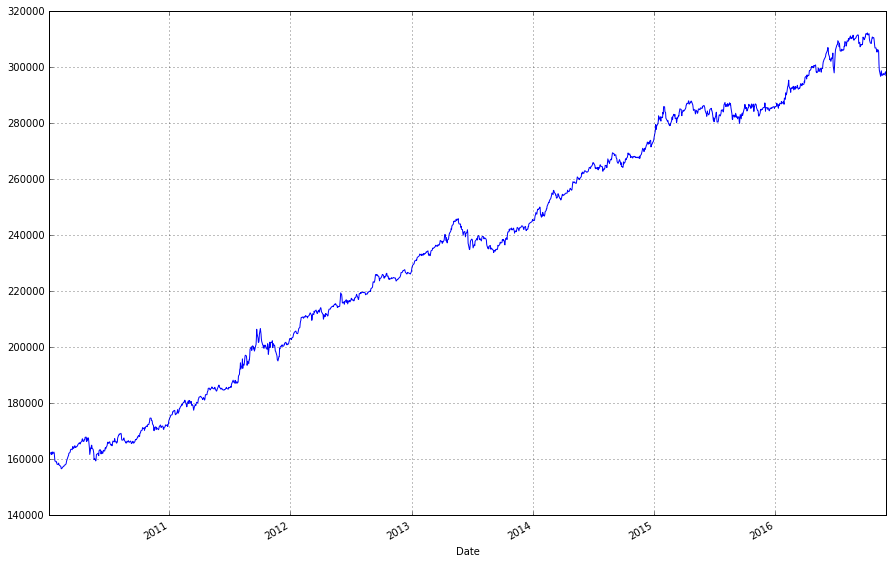

In [17]:
import datetime as dt
p_value[p_value.index > dt.datetime(2010,1,1)].plot(figsize=(15,10), grid=True)

#### What about using downside protection?

In [18]:
cash_proxy = 'FFXSX'
risk_free = 'FFXSX'

if risk_free == 'CASHX' :
    px = pd.DataFrame (columns=list(set([cash_proxy, risk_free])))
    tickers = [cash_proxy]
elif isinstance (risk_free, str) :
    px =  pd.DataFrame (columns=list(set([cash_proxy, risk_free])))
    tickers = [cash_proxy, risk_free]
else :
    px = pd.DataFrame (columns=[cash_proxy])

prices = strategy_values.copy().dropna()
prices = prices / prices.iloc[0]
for symbol in tickers :
    url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
    prices[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close'] 
    
prices = prices.dropna()
symbols = prices.columns

In [19]:
prices[:3]

,RS0001,PMA003,RS0002,PMA001,PMA002,DM0001,RS0003,DM0002,FFXSX
Date,,,,,,,,,
1986-12-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.379192
1987-01-02,1.001041,1.005854,1.000995,1.003911,1.004901,1.002646,1.000097,1.001986,2.379192
1987-01-05,1.002626,1.007805,1.001990,1.005479,1.006896,1.004352,1.001075,1.003407,2.379192


              RS0001    PMA003    RS0002    PMA001    PMA002    DM0001  \

Date                                                                     

1987-01-30  0.111111  0.111111  0.111111  0.111111  0.111111  0.111111   

1987-02-27  0.111111  0.111111  0.111111  0.111111  0.111111  0.111111   

1987-03-31  0.111111  0.111111  0.111111  0.000000  0.000000  0.111111   

1987-04-30  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

1987-05-29  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   



              RS0003    DM0002     FFXSX  

Date                                      

1987-01-30  0.111111  0.111111  0.111111  

1987-02-27  0.000000  0.111111  0.222222  

1987-03-31  0.111111  0.111111  0.333333  

1987-04-30  0.000000  0.000000  1.000000  

1987-05-29  0.000000  0.000000  1.000000  

FIRST BUY DATE = 1987-01-30 00:00:00




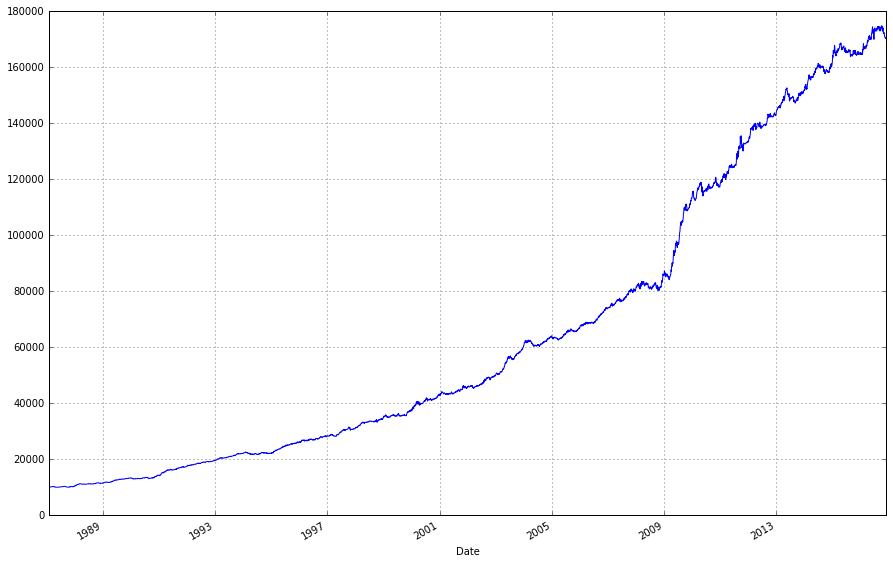

In [20]:
rs_lookback = 1
risk_lookback = 1
n_top = len(symbols)

frequency = 'm'

end_points = endpoints(period=frequency, trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0

if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()

rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

print (weights[:5])

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

The CAGR has dropped slightly but the Sharpe Ratio has increased significantly and the Max Drawdown has been reduced

In [21]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 1987-01-30 00:00:00 - 2016-11-30 00:00:00

Annual risk-free rate considered: 0.00%

Summary:

Total Return      Sharpe  CAGR    Max Drawdown

--------------  --------  ------  --------------

1604.50%            2.35  9.97%   -4.46%



Annualized Returns:

mtd     3m      6m      ytd    1y     3y     5y     10y    incep.

------  ------  ------  -----  -----  -----  -----  -----  --------

-0.99%  -2.02%  -0.99%  3.29%  3.20%  4.07%  5.10%  8.72%  9.97%



Periodic:

        daily    monthly    yearly

------  -------  ---------  --------

sharpe  2.35     2.18       1.52

mean    9.59%    9.64%      10.29%

vol     4.07%    4.41%      6.76%

skew    0.02     0.49       1.40

kurt    4.93     1.58       2.74

best    1.87%    6.03%      32.12%

worst   -2.49%   -2.43%     0.16%



Drawdowns:

max     avg       # days

------  ------  --------

-4.46%  -0.57%     16.68



Misc:

---------------  -------

avg. up month    1.27%

avg. down month  -0.79%

up year %     

G:\Anaconda3\lib\site-packages\ffn\core.py:190: FutureWarning: how in .resample() is deprecated

the new syntax is .resample(...).last()

  self.monthly_prices = obj.resample('M', how='last')

G:\Anaconda3\lib\site-packages\ffn\core.py:193: FutureWarning: how in .resample() is deprecated

the new syntax is .resample(...).last()

  self.yearly_prices = obj.resample('A', how='last')


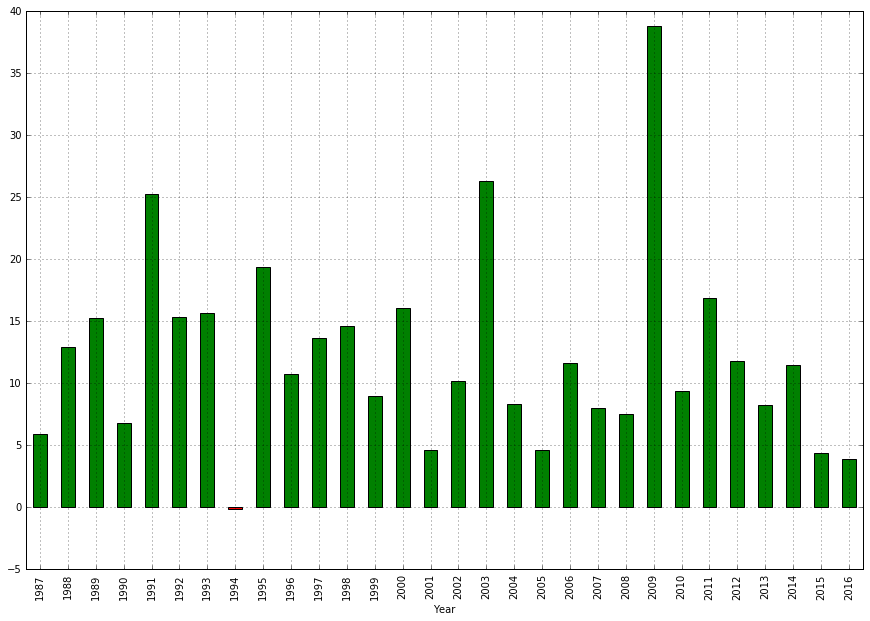

In [22]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

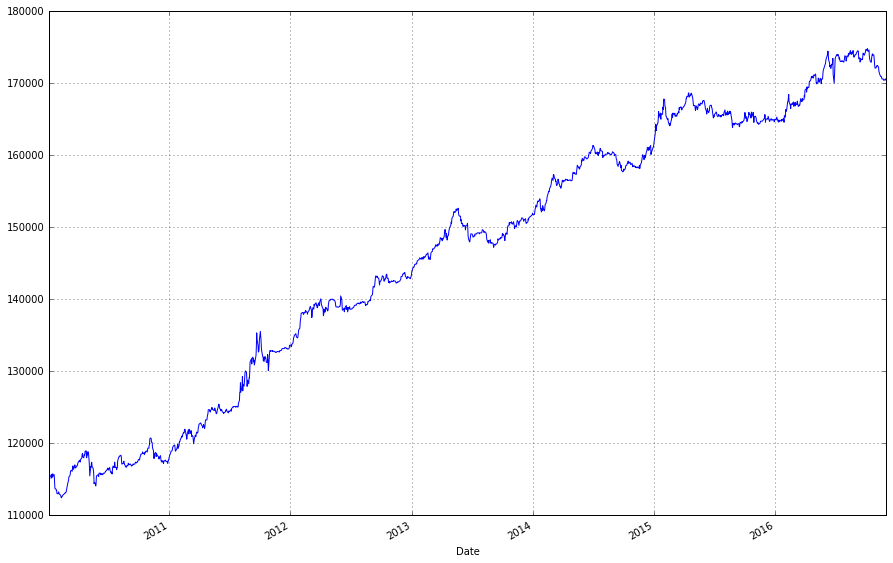

In [24]:
p_value[p_value.index > dt.datetime(2010,1,1)].plot(figsize=(15,10), grid=True)

In [27]:
p_holdings.loc[rebalance_dates].round(0)[:5]

,RS0001,PMA003,RS0002,PMA001,PMA002,DM0001,RS0003,DM0002,FFXSX
Date,,,,,,,,,
1987-01-30,1091.0,1100.0,1096.0,1099.0,1097.0,1094.0,1095.0,1095.0,463.0
1987-02-27,1081.0,1095.0,1109.0,1081.0,1080.0,1092.0,0.0,1093.0,943.0
1987-03-31,1084.0,1086.0,1106.0,0.0,0.0,1083.0,1115.0,1090.0,1421.0
1987-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4208.0
1987-05-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4208.0


this is not very helpful - we need to know what to order at each rebalance date

In [29]:
p_weights.loc[rebalance_dates].round(3)[:5]

,RS0001,PMA003,RS0002,PMA001,PMA002,DM0001,RS0003,DM0002,FFXSX
Date,,,,,,,,,
1987-01-30,0.111,0.111,0.111,0.111,0.111,0.111,0.111,0.111,0.111
1987-02-27,0.111,0.111,0.111,0.111,0.111,0.111,0.000,0.111,0.222
1987-03-31,0.111,0.111,0.111,0.000,0.000,0.111,0.111,0.111,0.333
1987-04-30,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1987-05-29,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


In [ ]:
portfolios = {'DM0001': {'symbols': list(strategies), 'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 3, 'frequency': 'm', 'cash_proxy': 'CASHX', 'risk_free': 'FFXSX'}}
              
p_value1, p_holdings1, p_weights1, prices1 =  compute_weights_RS_DM ('DM0001', portfolios['DM0001'])
p_value1.plot(figsize=(10, 8), grid=True)